<div style="border: 4px solid white; padding: 20px; background-color: #2596be; color: white;">

# <b>Explorative Datenanalyse mit Sparky</b>

#### <i>CAS Information Engineering - Modul: Big data - FS 2024</i>

<b> Autoren: </b> Hassler Robin, Tschanz Daniel, Tsiantas Theofanis (Gruppe 10)

</div>

# Teil 5 - Sparky und Vorhersage neuer Kunden mit Prophet

In [1]:
zhawaccount = 'tschadan'# TODO set this to your ZHAW-Kürzel

In [2]:
import sparky
import pyspark
import pandas as pd
#import slash
import pyspark.sql
sc = sparky.connect(f"sparknotebook-{zhawaccount}", 2)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

~~~ Sparky module loaded ~~~


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/30 13:01:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Attached to Sparky cluster context from jupyter-secondary as sparknotebook-tschadan.
Requested 2 cores; real number might be less.


In [3]:
# Bibliotheken
%pip install plotly
%pip install prophet

import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, to_date
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType
from datetime import datetime
from prophet import Prophet

## Parquet-Daten einlesen

In [4]:
df_customer_p = spark.read.parquet("./cleanedData/Customers.parquet", header=True, inferSchema=True)
df_customer_p.show()
df_customer_p.printSchema()

+--------------+------+--------+----------+
|Customernumber|Status|Currency|Entry Date|
+--------------+------+--------+----------+
|    K072870000|    10|     CHF|2023-07-06|
|    K01286ISX0|    20|     CHF|2023-07-24|
|    K04611AAO0|    20|     CHF|2023-07-27|
|    K04611AAR0|    20|     CHF|2023-07-27|
|    K04611AAX0|    20|     CHF|2023-07-27|
|    K04611AAY0|    20|     CHF|2023-07-27|
|    K04611ABH0|    20|     CHF|2023-07-28|
|    K11285BFG0|    20|     CHF|2023-07-31|
|    K01795BXD0|    20|     EUR|2023-08-02|
|    K01795BXP0|    20|     EUR|2023-08-02|
|    K01795BXQ0|    20|     EUR|2023-08-02|
|    K01795BYC0|    20|     EUR|2023-08-02|
|    K01795BYJ0|    20|     EUR|2023-08-02|
|    K01795BYM0|    20|     EUR|2023-08-02|
|    K01795BYN0|    20|     EUR|2023-08-02|
|    K11285BFH0|    20|     CHF|2023-08-07|
|    K027680000|    20|     CHF|2023-08-08|
|    K01286ITG0|    20|     CHF|2023-08-08|
|    K04230AKI0|    20|     CHF|2023-06-02|
|    K04230AKX0|    20|     CHF|

## Daten für Vorhersage vorbereiten

### Dateiformat Parquet-DataFrame definieren und reduzieren

In [5]:
# Prüfen Format "Entry Date" für Vorhersage
df_customer_p = df_customer_p.withColumn("Entry Date", to_date(col("Entry Date"), "yyyyMMdd"))

In [6]:
# Trainingsaten auf das Jahr ab 2021 reduzieren (weitere Reduktionen zu späterem Zeitpunkt)
df_customer_p_reduced = df_customer_p.filter((col("Entry Date") > "2020-12-31"))

### Monatlich neu aquirierte Kunden 2021

In [7]:
# Berechnung der täglich neu akquierten Kunden
rdd_customer = df_customer_p_reduced.rdd \
                .map(lambda x:x[3]) \
                .map(lambda x:[x, 1]) \
                .reduceByKey(lambda x,y:x+y) \
                .sortByKey()

rdd_customer.collect()

[(datetime.date(2021, 1, 4), 3),
 (datetime.date(2021, 1, 5), 5),
 (datetime.date(2021, 1, 6), 36),
 (datetime.date(2021, 1, 7), 26),
 (datetime.date(2021, 1, 8), 5),
 (datetime.date(2021, 1, 11), 4),
 (datetime.date(2021, 1, 13), 1),
 (datetime.date(2021, 1, 14), 6),
 (datetime.date(2021, 1, 15), 2),
 (datetime.date(2021, 1, 18), 1),
 (datetime.date(2021, 1, 19), 22),
 (datetime.date(2021, 1, 20), 7),
 (datetime.date(2021, 1, 21), 3),
 (datetime.date(2021, 1, 25), 2),
 (datetime.date(2021, 1, 26), 10),
 (datetime.date(2021, 1, 27), 3),
 (datetime.date(2021, 1, 28), 3),
 (datetime.date(2021, 2, 1), 14),
 (datetime.date(2021, 2, 2), 3),
 (datetime.date(2021, 2, 3), 12),
 (datetime.date(2021, 2, 4), 7),
 (datetime.date(2021, 2, 5), 1),
 (datetime.date(2021, 2, 8), 1),
 (datetime.date(2021, 2, 9), 2),
 (datetime.date(2021, 2, 10), 2),
 (datetime.date(2021, 2, 11), 4),
 (datetime.date(2021, 2, 12), 1),
 (datetime.date(2021, 2, 16), 19),
 (datetime.date(2021, 2, 17), 1),
 (datetime.date(202

In [8]:
# RDD nur auf Monatbasis mappen
rdd_customer_month = rdd_customer.map(lambda x: ((x[0].year, x[0].month), x[1]))

# Die Anzahl von Neukunden pro Monat des jeweiligen Jahres aufaddieren
rdd_aggregated = rdd_customer_month.reduceByKey(lambda a, b: a + b).sortByKey()

rdd_aggregated.collect()

[((2021, 1), 139),
 ((2021, 2), 92),
 ((2021, 3), 279),
 ((2021, 4), 145),
 ((2021, 5), 120),
 ((2021, 6), 107),
 ((2021, 7), 171),
 ((2021, 8), 114),
 ((2021, 9), 67),
 ((2021, 10), 74),
 ((2021, 11), 97),
 ((2021, 12), 47),
 ((2022, 1), 92),
 ((2022, 2), 62),
 ((2022, 3), 278),
 ((2022, 4), 197),
 ((2022, 5), 167),
 ((2022, 6), 227),
 ((2022, 7), 94),
 ((2022, 8), 237),
 ((2022, 9), 189),
 ((2022, 10), 156),
 ((2022, 11), 192),
 ((2022, 12), 186),
 ((2023, 1), 155),
 ((2023, 2), 160),
 ((2023, 3), 152),
 ((2023, 4), 133),
 ((2023, 5), 177),
 ((2023, 6), 148),
 ((2023, 7), 199),
 ((2023, 8), 126),
 ((2023, 9), 165),
 ((2023, 10), 230),
 ((2023, 11), 53),
 ((2023, 12), 256),
 ((2024, 1), 147),
 ((2024, 2), 191),
 ((2024, 3), 204),
 ((2024, 4), 189),
 ((2024, 5), 158),
 ((2024, 6), 161)]

In [9]:
# Datum RDD konvertieren
# a) tuple => string
rdd_string = rdd_aggregated.map(lambda x: (f"{x[0][0]}{x[0][1]:02d}", x[1]))
# b) string => DateTime
rdd_date_time = rdd_string.map(lambda x: (datetime.strptime(x[0], "%Y%m"), int(x[1])))

rdd_date_time.collect()

[(datetime.datetime(2021, 1, 1, 0, 0), 139),
 (datetime.datetime(2021, 2, 1, 0, 0), 92),
 (datetime.datetime(2021, 3, 1, 0, 0), 279),
 (datetime.datetime(2021, 4, 1, 0, 0), 145),
 (datetime.datetime(2021, 5, 1, 0, 0), 120),
 (datetime.datetime(2021, 6, 1, 0, 0), 107),
 (datetime.datetime(2021, 7, 1, 0, 0), 171),
 (datetime.datetime(2021, 8, 1, 0, 0), 114),
 (datetime.datetime(2021, 9, 1, 0, 0), 67),
 (datetime.datetime(2021, 10, 1, 0, 0), 74),
 (datetime.datetime(2021, 11, 1, 0, 0), 97),
 (datetime.datetime(2021, 12, 1, 0, 0), 47),
 (datetime.datetime(2022, 1, 1, 0, 0), 92),
 (datetime.datetime(2022, 2, 1, 0, 0), 62),
 (datetime.datetime(2022, 3, 1, 0, 0), 278),
 (datetime.datetime(2022, 4, 1, 0, 0), 197),
 (datetime.datetime(2022, 5, 1, 0, 0), 167),
 (datetime.datetime(2022, 6, 1, 0, 0), 227),
 (datetime.datetime(2022, 7, 1, 0, 0), 94),
 (datetime.datetime(2022, 8, 1, 0, 0), 237),
 (datetime.datetime(2022, 9, 1, 0, 0), 189),
 (datetime.datetime(2022, 10, 1, 0, 0), 156),
 (datetime.dat

### RDD für Prophet-Analyse in Spark DataFrame umwandeln

In [10]:
# Schema definieren
schema = StructType([
    StructField("ds", DateType()),
    StructField("y", IntegerType())
])

# RDD in PySpark DataFrame konvertieren
df_new_customer = spark.createDataFrame(rdd_date_time, schema)

# Datum string in DateTime konvertieren (yyyyMM)
#df_new_customer = df_new_customer.withColumn('ds', to_date(col('ds'), "yyyyMM"))

df_new_customer.show()
df_new_customer.printSchema()

df_new_customer_pd = df_new_customer.toPandas()

df_new_customer_pd.head(20)

+----------+---+
|        ds|  y|
+----------+---+
|2021-01-01|139|
|2021-02-01| 92|
|2021-03-01|279|
|2021-04-01|145|
|2021-05-01|120|
|2021-06-01|107|
|2021-07-01|171|
|2021-08-01|114|
|2021-09-01| 67|
|2021-10-01| 74|
|2021-11-01| 97|
|2021-12-01| 47|
|2022-01-01| 92|
|2022-02-01| 62|
|2022-03-01|278|
|2022-04-01|197|
|2022-05-01|167|
|2022-06-01|227|
|2022-07-01| 94|
|2022-08-01|237|
+----------+---+
only showing top 20 rows

root
 |-- ds: date (nullable = true)
 |-- y: integer (nullable = true)



,ds,y
0,2021-01-01,139
1,2021-02-01,92
2,2021-03-01,279
3,2021-04-01,145
4,2021-05-01,120
5,2021-06-01,107
6,2021-07-01,171
7,2021-08-01,114
8,2021-09-01,67
9,2021-10-01,74


## Explanation and Execution of Prophet Forecasts

**ds (Date Series):**

This column contains the timestamps for the forecasted values. It corresponds to the future dates for which the forecast has been generated.

**yhat (Forecasted Value):**

This column contains the forecasted values of the time series. It is the primary output of the Prophet model and represents the predicted values for the corresponding dates in the ds column.

**yhat_lower (Lower Bound of Forecast):**

This column contains the lower bound of the forecasted values' uncertainty interval. It provides a conservative estimate of the forecast, giving an idea of the potential minimum value the forecast might take.

**yhat_upper (Upper Bound of Forecast):**

This column contains the upper bound of the forecasted values' uncertainty interval. It provides a liberal estimate of the forecast, giving an idea of the potential maximum value the forecast might take.

### Zeitspanne DataFrames definieren

In [11]:
# Daten in Forecast-Set und Test-Set splitten
date_begin_forecast = pd.to_datetime('2022-01-01')
date_end_forecast = pd.to_datetime('2022-07-01')

# Forecast Set (vor 2022-01-01)
df_modell_forecast = df_new_customer_pd[df_new_customer_pd['ds'] < date_begin_forecast]

# Test Set (2022-01-01 bis 2022-06-30, ohne weitere Daten)
df_modell_test = df_new_customer_pd[(df_new_customer_pd['ds'] >= date_begin_forecast) & (df_new_customer_pd['ds'] < date_end_forecast)]

print("Forecast Set:")
print(df_modell_forecast.head(20))
print("\nTest Set:")
print(df_modell_test.head(20))

Forecast Set:
            ds    y
0   2021-01-01  139
1   2021-02-01   92
2   2021-03-01  279
3   2021-04-01  145
4   2021-05-01  120
5   2021-06-01  107
6   2021-07-01  171
7   2021-08-01  114
8   2021-09-01   67
9   2021-10-01   74
10  2021-11-01   97
11  2021-12-01   47

Test Set:
            ds    y
12  2022-01-01   92
13  2022-02-01   62
14  2022-03-01  278
15  2022-04-01  197
16  2022-05-01  167
17  2022-06-01  227


/tmp/ipykernel_8906/2078726477.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_modell_forecast = df_new_customer_pd[df_new_customer_pd['ds'] < date_begin_forecast]
/tmp/ipykernel_8906/2078726477.py:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_modell_test = df_new_customer_pd[(df_new_customer_pd['ds'] >= date_begin_forecast) & (df_new_customer_pd['ds'] < date_end_forecast)]


### Prophet Modelle initialisieren

In [12]:
# Modell initialisieren
model = Prophet(interval_width=0.95, daily_seasonality=True)

# Modell mit daten trainieren
model.fit(df_modell_forecast)

# Create a DataFrame to hold future dates for forecasting
future = model.make_future_dataframe(periods=6, freq='M')  # Forecasting 6 months into the future from 2022-01-01 on

# Generate the forecast
forecast = model.predict(future)

# Print all months
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(20))

# Print the 6 forecasted months
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

13:02:07 - cmdstanpy - INFO - Chain [1] start processing
13:02:08 - cmdstanpy - INFO - Chain [1] done processing


           ds        yhat  yhat_lower  yhat_upper
0  2021-01-01  173.935770   74.881994  265.753318
1  2021-02-01  164.067002   71.500502  252.594512
2  2021-03-01  155.153276   65.035061  241.083568
3  2021-04-01  145.284509   47.630932  238.572512
4  2021-05-01  135.734088   41.032487  235.602945
5  2021-06-01  125.865320   25.351576  217.033667
6  2021-07-01  116.314899   25.969370  207.032538
7  2021-08-01  106.446131   16.024530  200.111106
8  2021-09-01   96.577363   -0.803955  195.038737
9  2021-10-01   87.026943   -8.203938  186.654554
10 2021-11-01   77.158175   -8.983917  174.518538
11 2021-12-01   67.607754  -26.959037  162.625009
12 2021-12-31   58.057334  -36.259900  150.171731
13 2022-01-31   48.188566  -36.849376  142.130360
14 2022-02-28   39.274840  -48.459156  132.042374
15 2022-03-31   29.406072  -58.809938  120.721373
16 2022-04-30   19.855651  -73.300229  111.343330
17 2022-05-31    9.986883  -73.101994  103.937277


,ds,yhat,yhat_lower,yhat_upper
12,2021-12-31,58.057334,-36.259900,150.171731
13,2022-01-31,48.188566,-36.849376,142.130360
14,2022-02-28,39.274840,-48.459156,132.042374
15,2022-03-31,29.406072,-58.809938,120.721373
16,2022-04-30,19.855651,-73.300229,111.343330
17,2022-05-31,9.986883,-73.101994,103.937277


In [13]:
# Prophet Modell mit 0 Monaten Prognose für gleiches Plotting der Vergleichsdaten (01.01.2022-30.06.2022)
model = Prophet(interval_width=0.95, daily_seasonality=True)
model.fit(df_modell_test)
future = model.make_future_dataframe(periods=0, freq='M') 
forecast_test = model.predict(future)

forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

13:02:08 - cmdstanpy - INFO - Chain [1] start processing
13:02:08 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,106.736349,-13.198053,226.023424
1,2022-02-01,133.035346,19.451391,242.189551
2,2022-03-01,156.789278,45.512696,288.867697
3,2022-04-01,183.088275,71.805128,300.228875
4,2022-05-01,208.538918,94.111977,320.435726
5,2022-06-01,234.837915,115.366555,352.385166


## Plotting Vorhersage und Vergleich mit Echtdaten

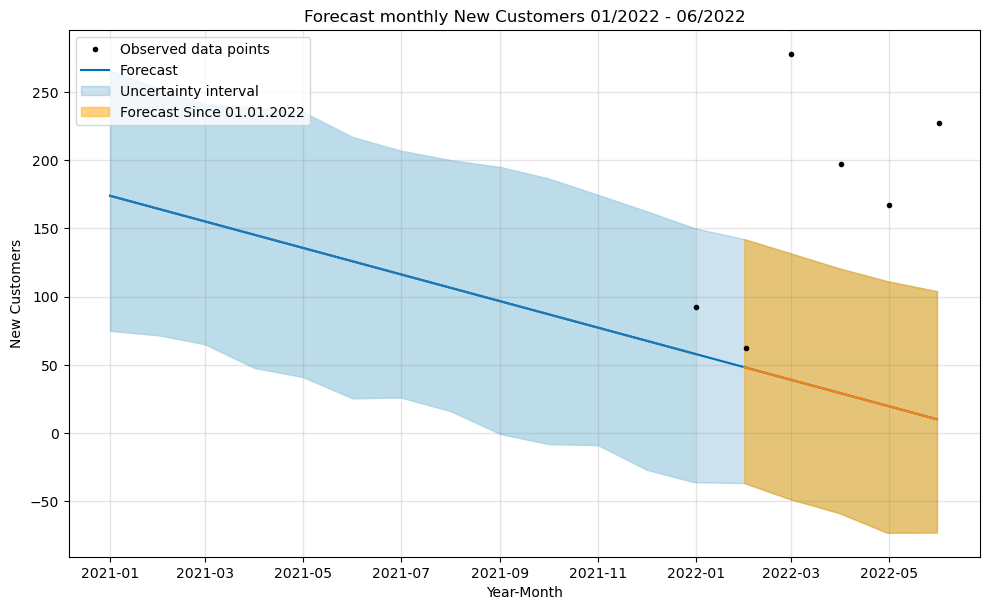

In [14]:
# Plotanzeige in Zetiraum Echtdaten und Vorhersage-Daten splitten
date_split = pd.to_datetime('2022-01-01')
forecast_before = forecast[forecast['ds'] < date_split]
forecast_after = forecast[forecast['ds'] >= date_split]

# Plot the forecast
fig1 = model.plot(forecast)

# Customize the plot
ax = fig1.gca()  # Get the current axes
ax.set_xlabel('Year-Month')
ax.set_ylabel('New Customers')
ax.set_title('Forecast monthly New Customers 01/2022 - 06/2022')

# Plot the forecast lines with different colors
ax.plot(forecast_before['ds'], forecast_before['yhat'])
ax.plot(forecast_after['ds'], forecast_after['yhat'])

# Konfidenzintervalle für Echtdaten und Vorhersagedaten definieren
ax.fill_between(forecast_before['ds'], forecast_before['yhat_lower'], forecast_before['yhat_upper'], color='lightblue', alpha=0.5)
ax.fill_between(forecast_after['ds'], forecast_after['yhat_lower'], forecast_after['yhat_upper'], color='orange', alpha=0.5, label='Forecast Since 01.01.2022')

# Adding the legend again to ensure it captures the custom interval
ax.legend()

# Show the plot
plt.show()

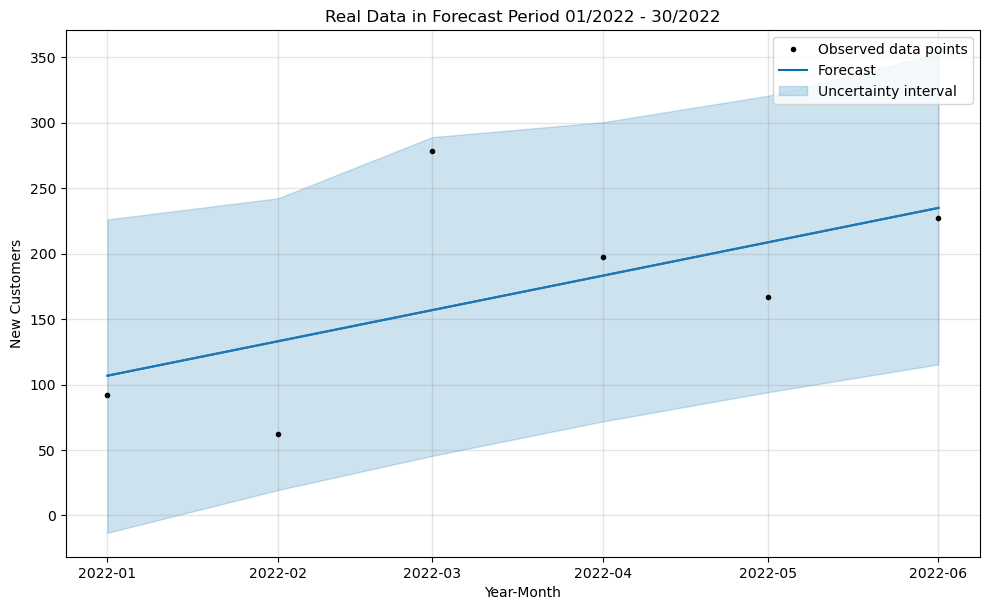

In [15]:
# Plot the real Data (01.01.2022-30.06.2022)
fig2 = model.plot(forecast_test)
ax = fig2.gca()  # Get the current axes
ax.set_xlabel('Year-Month')
ax.set_ylabel('New Customers')
ax.set_title('Real Data in Forecast Period 01/2022 - 30/2022')
ax.plot(forecast_test['ds'], forecast_test['yhat'])
ax.legend()
plt.show()

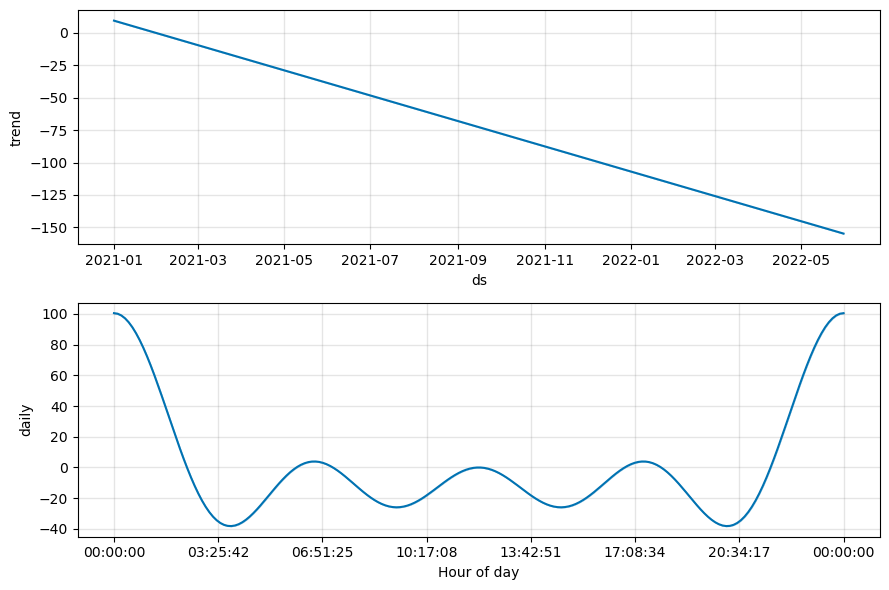

In [16]:
# Plot the forecast components
fig3 = model.plot_components(forecast)
plt.show()

In [17]:
sc.stop()

Sources:
- https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a
- https://www.kaggle.com/code/kakkarot/starter-hourly-energy-consumption-b71f2600-a
- https://www.youtube.com/watch?v=KvLG1uTC-KU